In [1]:
!pip install datasets
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [2]:
#Loading the Xsum dataset from Hugging Face
import tensorflow as tf
from datasets import load_dataset

dataset = load_dataset("xsum")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


(…)SUM-EMNLP18-Summary-Data-Original.tar.gz:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [3]:
import pandas as pd

#Spliting the dataset
train_data = dataset['train']
test_data = dataset['test']
val_data = dataset['validation']

#Converting the Hugging Face Dataset into a pandas Dataframe
full_train_df = pd.DataFrame(train_data)
full_test_df = pd.DataFrame(test_data)
full_val_df = pd.DataFrame(val_data)

In [4]:
from bs4 import BeautifulSoup
import html
def clean_xsum_text(text):
    # Suppression des balises HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    # Décodage des entités HTML
    text = html.unescape(text)
    # Suppression des caractères spéciaux
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    # Réduction des espaces multiples
    text = ' '.join(text.split())
    # Suppression des mentions non informatives (exemple)
    for pattern in ["BBC News", "Read more", "Copyright"]:
        text = text.replace(pattern, "")
    return text.strip()

In [5]:
full_train_df['document'] = full_train_df['document'].apply(clean_xsum_text)
full_val_df['document'] = full_val_df['document'].apply(clean_xsum_text)
full_test_df['document'] = full_test_df['document'].apply(clean_xsum_text)

In [6]:
from sklearn.model_selection import train_test_split

ft_train, train_df = train_test_split(full_train_df, test_size=0.30, random_state=0)
ft_test, test_df = train_test_split(full_test_df, test_size=0.30, random_state=0)
ft_val, val_df = train_test_split(full_val_df, test_size=0.30, random_state=0)

In [7]:
display(test_df.head(5))

,document,summary,id
125,"The exhibition, From Dark to Light, explores t...",A collection of paintings capturing the landsc...,33446602
1741,Ex-French Minister for Health and Sport Rosely...,"Real Madrid backed ""exemplary"" club member Raf...",35794268
7388,The man was once a specialist in chemical and ...,A chemical weapons expert from the Islamic Sta...,35768377
1654,The duo are the first Robins players to agree ...,Guernsey FC have signed Bristol City forward J...,38195866
6358,The 34-year-old has recently returned from a s...,Motherwell have signed Stephen Pearson until t...,38842342


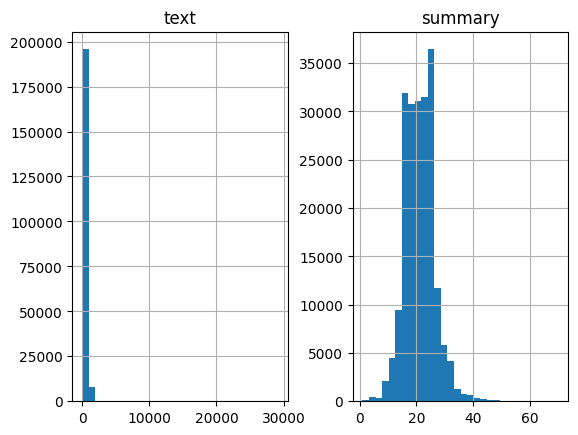

In [8]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in full_train_df['document']:
      text_word_count.append(len(i.split()))

for j in full_train_df['summary']:
      summary_word_count.append(len(j.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [37]:
import json
import os
import time
from tensorflow.keras.models import save_model
from google.colab import drive

def save_training_results(CONFIG, history, model):
    # 1. Monter Google Drive (si pas déjà fait)
    drive.mount('/content/drive', force_remount=True)  # Force le remontage si nécessaire

    # 2. Définir le chemin ABSOLU dans Google Drive
    DRIVE_ROOT = "/content/drive/MyDrive/saved_models"  # Dossier racine persistant

    # 3. Créer le dossier racine si inexistant
    os.makedirs(DRIVE_ROOT, exist_ok=True)  # Crée saved_models dans Drive si nécessaire

    # 4. Générer le chemin unique pour ce modèle
    unique_id = f"{CONFIG['name']}_{int(time.time())}"
    save_dir = os.path.join(DRIVE_ROOT, unique_id)
    os.makedirs(save_dir, exist_ok=True)  # Crée le sous-dossier unique

    # 5. Sauvegarder le modèle
    model.save(os.path.join(save_dir, "model.keras"))  # Format Keras standard

    # 6. Préparer les métriques (inchangé)
    metrics = {
        "loss": history.history["loss"][-1],
        "val_loss": history.history["val_loss"][-1],
        "accuracy": history.history["accuracy"][-1],
        "val_accuracy": history.history["val_accuracy"][-1]
    }

    # 7. Créer l'entrée JSON
    entry = {
        "model_id": unique_id,
        "config": CONFIG,
        "metrics": metrics,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_path": os.path.join(save_dir, "model.keras")
    }

    # 8. Chemin ABSOLU du fichier JSON maître
    master_json = os.path.join(DRIVE_ROOT, "training_results.json")

    # 9. Créer le fichier JSON s'il n'existe pas
    if not os.path.exists(master_json):
        with open(master_json, "w") as f:
            json.dump([], f)  # Initialise avec une liste vide

    # 10. Mettre à jour le JSON
    with open(master_json, "r+") as f:
        data = json.load(f)
        data.append(entry)
        f.seek(0)
        json.dump(data, f, indent=4)

In [190]:
#Hyperparameters
CONFIG={
  'name': "transformers_with_es",
  'num_words_doc': 50000,
  'num_words_sum': 10000,
  'max_doc_length': 600,
  'max_sum_length': 40,
  'embedding_dim': 128,
  'ff_dim': 512,
  'num_heads': 4,
  'num_layers': 2,
  'learning_rate': 3e-4,
  'nb_batch': 64,
  'nb_epochs': 10,
}

In [147]:
summaries_with_tokens = ['sostok ' + s + ' eostok' for s in train_df['summary']]
display(summaries_with_tokens[:5])

["sostok Members of the left-wing Colombian Farc rebel group opposed to last year's historic peace agreement have killed a soldier in an attack in the south-east of the country, the army has said. eostok",
 'sostok A South Korean man who was abducted by North Korea 41 years ago has managed to return home, officials in Seoul say. eostok',
 "sostok Russia's Alexander Povetkin has tested positive for meldonium ahead of his WBC world title fight with Deontay Wilder. eostok",
 'sostok Kemar Roofe netted a first hat-trick of his 25-goal season as Oxford United made light work of struggling Dagenham. eostok',
 'sostok A 33-year-old man has appeared in court charged with murdering another man in North Lanarkshire. eostok']

In [148]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization des documents et résumés [2][4]
tokenizer_doc = Tokenizer(CONFIG['num_words_doc'], oov_token='<OOV>')
tokenizer_sum = Tokenizer(CONFIG['num_words_sum'], oov_token='<OOV>')

tokenizer_doc.fit_on_texts(list(train_df['document']))
tokenizer_sum.fit_on_texts(summaries_with_tokens)

In [173]:
#Training set padding
encoder_input_train = tokenizer_doc.texts_to_sequences(train_df['document'])
encoder_input_train = pad_sequences(encoder_input_train, maxlen=CONFIG['max_doc_length'], padding='post')

# Decoder (summaries avec <sostok> et <eostok>)
decoder_train_seq = tokenizer_sum.texts_to_sequences(['sostok ' + s + ' eostok' for s in train_df['summary']])
decoder_train_seq = pad_sequences(decoder_train_seq, maxlen=CONFIG['max_sum_length'], padding='post')

# Split en input (sans dernier token) et output (sans premier token)
decoder_input_train = decoder_train_seq[:, :-1]
decoder_output_train = decoder_train_seq[:, 1:]



#Validation set padding
encoder_input_val = tokenizer_doc.texts_to_sequences(val_df['document'])
encoder_input_val = pad_sequences(encoder_input_val, maxlen=CONFIG['max_doc_length'], padding='post')

# Decoder (summaries avec <sostok> et <eostok>)
decoder_val_seq = tokenizer_sum.texts_to_sequences(['sostok ' + s + ' eostok' for s in val_df['summary']])
decoder_val_seq = pad_sequences(decoder_val_seq, maxlen=CONFIG['max_sum_length'], padding='post')

# Split en input (sans dernier token) et output (sans premier token)
decoder_input_val = decoder_val_seq[:, :-1]
decoder_output_val = decoder_val_seq[:, 1:]

In [174]:
# ---------------------------
# Fonction de perte personnalisée
# ---------------------------
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

def masked_loss(y_true, y_pred):
    loss = loss_object(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), dtype=loss.dtype)  # 0 = padding
    loss *= mask

    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [175]:
# ---------------------------
# Optimiseur
# ---------------------------
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=CONFIG['learning_rate'],
    decay_steps=10000,
    decay_rate=0.95
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

In [176]:
# === Mécanismes de masquage ===
def create_padding_mask(seq):
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def create_masks(inp, tar):
    # Masque pour l'encodeur
    enc_padding_mask = create_padding_mask(inp)

    # Masque pour le décodeur
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [177]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# --- Position Encoding ---
class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super().__init__()
        self.pos_encoding = self.get_positional_encoding(maxlen, embed_dim)

    def get_positional_encoding(self, maxlen, embed_dim):
        angle_rads = self.get_angles(
            np.arange(maxlen)[:, np.newaxis],
            np.arange(embed_dim)[np.newaxis, :],
            embed_dim
        )
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# --- Transformer Blocks ---
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs, training, mask=None):
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerDecoderLayer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)
        self.dropout3 = layers.Dropout(dropout)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        attn1 = self.att1(x, x, attention_mask=look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)

        attn2 = self.att2(out1, enc_output, enc_output, attention_mask=padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm3(out2 + ffn_output)

# --- Mask creation (must be used inside call) ---
def create_padding_mask(seq):
    return tf.cast(tf.math.equal(seq, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    return 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

# --- Transformer Model (custom Model subclass) ---
class TransformerSummarizer(keras.Model):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Deux embeddings séparés
        self.embedding_doc = layers.Embedding(config['num_words_doc'], config['embedding_dim'])
        self.embedding_sum = layers.Embedding(config['num_words_sum'], config['embedding_dim'])

        self.pos_enc_input = PositionalEncoding(config['max_doc_length'], config['embedding_dim'])
        self.pos_enc_target = PositionalEncoding(config['max_sum_length'], config['embedding_dim'])

        self.encoder_layers = [
            TransformerEncoderLayer(config['embedding_dim'], config['num_heads'], config['ff_dim'])
            for _ in range(config['num_layers'])
        ]
        self.decoder_layers = [
            TransformerDecoderLayer(config['embedding_dim'], config['num_heads'], config['ff_dim'])
            for _ in range(config['num_layers'])
        ]
        self.final_layer = layers.Dense(config['num_words_sum'], activation="softmax")

    def call(self, inputs, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
      inp, tar = inputs

      # Si les masques ne sont pas fournis (ex: en mode entraînement), on les crée
      if enc_padding_mask is None:
          enc_padding_mask = create_padding_mask(inp)
      if dec_padding_mask is None:
          dec_padding_mask = create_padding_mask(inp)
      if look_ahead_mask is None:
          size = tf.shape(tar)[1]
          look_ahead_mask = create_look_ahead_mask(size)
          look_ahead_mask = tf.maximum(create_padding_mask(tar), look_ahead_mask)

      # Embedding + position encoding
      enc_embed = self.embedding_doc(inp)
      dec_embed = self.embedding_sum(tar)
      x = self.pos_enc_input(enc_embed)
      y = self.pos_enc_target(dec_embed)

      # Encoder
      for layer in self.encoder_layers:
          x = layer(x, training=training, mask=enc_padding_mask)

      # Decoder
      for layer in self.decoder_layers:
          y = layer(y, x, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

      return self.final_layer(y)

In [178]:
from tensorflow.keras import Model

# -----------------------------
# Construction du modèle complet
# -----------------------------
def build_transformer(config):
    inputs = tf.keras.Input(shape=(config['max_doc_length'],), name='inputs')
    targets = tf.keras.Input(shape=(config['max_sum_length'],), name='targets')

    # Masques
    enc_padding_mask = layers.Lambda(create_padding_mask)(inputs)
    look_ahead_mask = layers.Lambda(lambda x: create_look_ahead_mask(config['max_sum_length']))(targets)
    dec_padding_mask = layers.Lambda(create_padding_mask)(inputs)

    embedding = layers.Embedding(config['num_words_doc'], config['embedding_dim'])

    enc = embedding(inputs)
    enc = PositionalEncoding(config['max_doc_length'], config['embedding_dim'])(enc)
    for _ in range(config['num_layers']):
        enc = TransformerEncoderLayer(config['embedding_dim'], config['num_heads'], config['ff_dim'])(enc, training=True, mask=enc_padding_mask)

    dec = embedding(targets)
    dec = PositionalEncoding(config['max_sum_length'], config['embedding_dim'])(dec)
    for _ in range(config['num_layers']):
        dec = TransformerDecoderLayer(config['embedding_dim'], config['num_heads'], config['ff_dim'])(dec, enc, training=True, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

    outputs = layers.Dense(config['num_words_sum'], activation='softmax')(dec)

    return Model(inputs=[inputs, targets], outputs=outputs)

In [179]:
model = TransformerSummarizer(CONFIG)

In [180]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [191]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# Compilation [4]
model.compile(
    optimizer=optimizer,
    loss=masked_loss,
    metrics=['accuracy']
)

In [192]:
# Entraînement
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_output_train,
    batch_size=CONFIG['nb_batch'],
    epochs=CONFIG['nb_epochs'],
    callbacks = [es],
    validation_data=([encoder_input_val, decoder_input_val], decoder_output_val)
)

Epoch 1/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 282s 268ms/step - accuracy: 0.5751 - loss: 0.0290 - val_accuracy: 0.5752 - val_loss: 0.0056
Epoch 2/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 284s 245ms/step - accuracy: 0.5755 - loss: 0.0094 - val_accuracy: 0.5753 - val_loss: 0.0018
Epoch 3/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 262s 245ms/step - accuracy: 0.5755 - loss: 0.0035 - val_accuracy: 0.5752 - val_loss: 9.2205e-04
Epoch 4/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 263s 246ms/step - accuracy: 0.5751 - loss: 0.0016 - val_accuracy: 0.5753 - val_loss: 1.9633e-04
Epoch 5/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 234s 244ms/step - accuracy: 0.5752 - loss: 7.5556e-04 - val_accuracy: 0.5753 - val_loss: 2.0754e-04
Epoch 6/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 235s 246ms/step - accuracy: 0.5760 - loss: 6.7509e-04 - val_accuracy: 0.5753 - val_loss: 1.1708e-04
Epoch 7/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 262s 245ms/step - accuracy: 0.5755 - loss: 4.1231e-04 - val_accuracy: 0.5753 - val_loss: 2.8351e-05
Epoch 8/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 261s

In [193]:
save_training_results(CONFIG, history, model)

Mounted at /content/drive


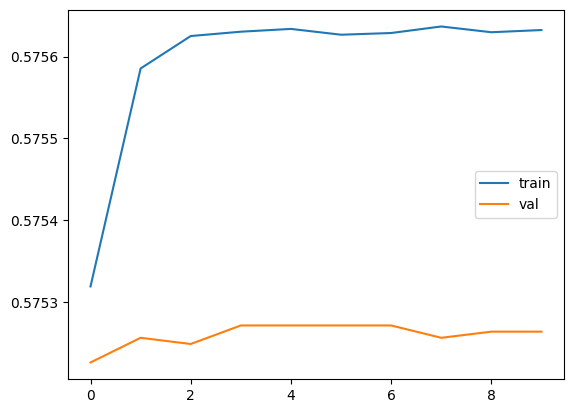

In [194]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

In [184]:
def infer_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def infer_create_look_ahead_mask(size):
    # Crée un masque de type causality avec des 1 dans la zone supérieure (non autorisée)
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # shape: (size, size)

def create_inference_masks(enc_input, dec_input):
    # Masque de padding pour l'encodeur
    enc_padding_mask = tf.cast(tf.math.equal(enc_input, 0), tf.float32)  # (batch_size, seq_len)
    enc_padding_mask = enc_padding_mask[:, tf.newaxis, tf.newaxis, :]    # (batch_size, 1, 1, seq_len)

    # Masque de padding pour le décodeur
    dec_padding_mask = tf.cast(tf.math.equal(enc_input, 0), tf.float32)
    dec_padding_mask = dec_padding_mask[:, tf.newaxis, tf.newaxis, :]    # (batch_size, 1, 1, seq_len)

    # Look-ahead mask
    seq_len = tf.shape(dec_input)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    look_ahead_mask = tf.cast(look_ahead_mask, tf.float32)

    dec_target_padding_mask = tf.cast(tf.math.equal(dec_input, 0), tf.float32)
    dec_target_padding_mask = dec_target_padding_mask[:, tf.newaxis, :, tf.newaxis]

    combined_mask = tf.maximum(
        look_ahead_mask[tf.newaxis, tf.newaxis, :, :],  # (1, 1, seq_len, seq_len)
        dec_target_padding_mask                         # (batch_size, 1, seq_len, 1)
    )

    return enc_padding_mask, combined_mask, dec_padding_mask

In [185]:
def top_k_logits(logits, k):
    values, indices = tf.math.top_k(logits, k=k)
    probs = tf.nn.softmax(values).numpy().flatten()
    return np.random.choice(indices.numpy().flatten(), p=probs)

def generate_summary(document, model):
    # Tokenisation et padding du document
    input_seq = tokenizer_doc.texts_to_sequences([document])
    input_seq = keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=CONFIG['max_doc_length'], padding='post')

    encoder_input = tf.convert_to_tensor(input_seq)

    start_token = tokenizer_sum.word_index['sostok']
    end_token = tokenizer_sum.word_index['eostok']

    output_sequence = [start_token]

    for _ in range(CONFIG['max_sum_length']):
        decoder_input = tf.convert_to_tensor([output_sequence])

        # Création des masques corrects
        enc_padding_mask, combined_mask, dec_padding_mask = create_inference_masks(encoder_input, decoder_input)

        # Appel du modèle avec masques passés explicitement
        predictions = model(
            [encoder_input, decoder_input],
            training=False,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask
        )

        logits = predictions[:, -1, :] / 0.8  # température
        predicted_id = top_k_logits(logits, k=10)  # top-k sampling

        if predicted_id == end_token:
            break

        output_sequence.append(predicted_id)

    summary_tokens = [tokenizer_sum.index_word.get(i, '') for i in output_sequence[1:]]
    return ' '.join(summary_tokens).strip()

In [195]:
sample_doc = val_df['document'].iloc[0]
sample_doc

'Physicists hope it could lead to discoveries that could potentially represent the biggest revolution in physics since Einstein\'s theories of relativity. Among them is Prof Jordan Nash from Imperial College London, who is working on the CMS experiment at the LHC. "We are opening a new window on the Universe and looking forward to seeing what\'s there," he said. "As much as we have a lot of theories of what might be out there we don\'t know. We\'d love to find something completely unexpected and we might, and that\'s the exciting bit." They want a glimpse into a world never seen before. By smashing atoms harder than they have been smashed before physicists hope to peel back another veil of reality. The aim of the various theories of physics is to explain how the Universe was formed and how the bits that make it up work. One of the most successful of these theories is called the "Standard Model". It explains how the world of the very, very small works. Just as the world became very stra

In [196]:
summary = generate_summary(sample_doc, model)

In [197]:
val_df['summary'].iloc[0]

'The Large Hadron Collider (LHC) has been restarted after a two-year shutdown.'

In [198]:
summary

'legal worth threatening legal worth nations offer worth winning offer threatening ways offer offer did legal winning threatening legal threatening legal threatening nations nations suffering did did offer winning nations threatening special record get legal did running known'